In [1]:
pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')


In [3]:
import pandas as pd
import random

data1 = pd.read_csv("~/Desktop/methyl-vae/data-test/wine_train.csv")
data2 = pd.read_csv("~/Desktop/methyl-vae/data-test/wine_test.csv")

# Predictor features (all columns except 'quality')
X_train = data1.drop(columns=['quality'])
X_test = data2.drop(columns=['quality'])

# Target feature ('quality' column)
y_train = data1['quality']
y_test = data2['quality']

In [4]:
#from ucimlrepo import fetch_ucirepo

# fetch dataset
#wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
#X = wine_quality.data.features
#y = wine_quality.data.targets

random.seed(123)

In [5]:
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,6.6,0.240,0.35,7.70,0.031,36.0,135.0,0.99380,3.19,0.37,10.5
1,8.3,0.280,0.48,2.10,0.093,6.0,12.0,0.99408,3.26,0.62,12.4
2,7.7,0.715,0.01,2.10,0.064,31.0,43.0,0.99371,3.41,0.57,11.8
3,5.2,0.370,0.33,1.20,0.028,13.0,81.0,0.99020,3.37,0.38,11.7
4,6.6,0.260,0.56,15.40,0.053,32.0,141.0,0.99810,3.11,0.49,9.3
...,...,...,...,...,...,...,...,...,...,...,...
5192,7.6,0.320,0.58,16.75,0.050,43.0,163.0,0.99990,3.15,0.54,9.2
5193,5.6,0.280,0.27,3.90,0.043,52.0,158.0,0.99202,3.35,0.44,10.7
5194,6.4,0.370,0.20,5.60,0.117,61.0,183.0,0.99459,3.24,0.43,9.5
5195,6.5,0.260,0.50,8.00,0.051,46.0,197.0,0.99536,3.18,0.47,9.5


In [6]:
X_test

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.0,0.170,0.74,12.8,0.045,24.0,126.0,0.99420,3.26,0.38,12.2
1,7.7,0.640,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9
2,6.8,0.390,0.34,7.4,0.020,38.0,133.0,0.99212,3.18,0.44,12.0
3,6.3,0.280,0.47,11.2,0.040,61.0,183.0,0.99592,3.12,0.51,9.5
4,7.4,0.350,0.20,13.9,0.054,63.0,229.0,0.99888,3.11,0.50,8.9
...,...,...,...,...,...,...,...,...,...,...,...
1295,10.7,0.900,0.34,6.6,0.112,23.0,99.0,1.00289,3.22,0.68,9.3
1296,5.7,0.245,0.33,1.1,0.049,28.0,150.0,0.99270,3.13,0.42,9.3
1297,6.6,0.160,0.35,1.8,0.042,26.0,105.0,0.98962,3.19,0.75,12.4
1298,6.6,0.390,0.38,9.7,0.053,49.0,226.0,0.99787,3.30,0.57,9.4


In [7]:
y_test

0       8
1       5
2       7
3       6
4       6
       ..
1295    5
1296    5
1297    7
1298    6
1299    7
Name: quality, Length: 1300, dtype: int64

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

latent_dim = 2  # Dimensionality of the latent space
input_dim = 11  # Dimensionality of the input data


# Standardize the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Split the train data into train and test(validation) sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

# Encoder
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(32, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# Define encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)

# Define decoder model
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, outputs, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss='mse')

# Train VAE
vae.fit(X_train1, y_train1, epochs=200, batch_size=8, validation_data=(X_test1, y_test1))

# Extract latent space representations for some input data
encoded_data_VAE = encoder.predict(X_test)[0]  # Extract z_mean


/Users/tyronemariano/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - loss: 19.0516 - val_loss: 1.9483
Epoch 2/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 1.8648 - val_loss: 1.1215
Epoch 3/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.9544 - val_loss: 0.8990
Epoch 4/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.7756 - val_loss: 0.7844
Epoch 5/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.6720 - val_loss: 0.6923
Epoch 6/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.6064 - val_loss: 0.6278
Epoch 7/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.5915 - val_loss: 0.6254
Epoch 8/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 0.5282 - val_loss: 0.5967
Epoch 9/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.5330 - val_loss: 0.5673
Epoch 10/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 0.4914 - val_loss: 0.5606
Epoch 11/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.5077 - val_loss: 0.5595
Epoch 12/200
520/5

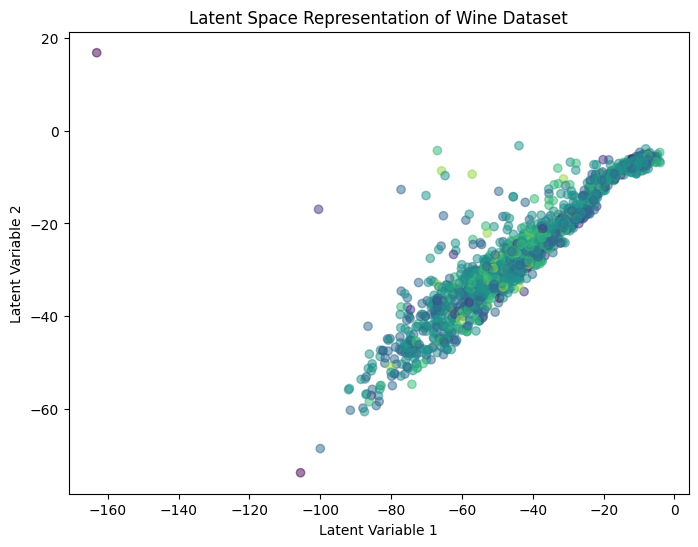

In [9]:
import matplotlib.pyplot as plt

# Plot encoded data
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_VAE[:, 0], encoded_data_VAE[:, 1], c=y_test, alpha=0.5)
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Space Representation of Wine Dataset')
plt.show()

In [10]:
VAE_df = pd.DataFrame(encoded_data_VAE)

#Rename columns
new_column_names = {0: 'VAE1', 1: 'VAE2'}
VAE_df = VAE_df.rename(columns=new_column_names)

# Add target class to the DataFrame
VAE_df['target'] = y_test

In [11]:
VAE_df

,VAE1,VAE2,target
0,-52.648811,-37.799866,8
1,-49.722420,-30.597689,5
2,-53.307610,-32.094814,7
3,-71.354759,-39.603367,6
4,-85.612289,-51.835552,6
...,...,...,...
1295,-43.610348,-28.964417,5
1296,-50.991100,-33.195320,5
1297,-40.967129,-24.990423,7
1298,-80.035568,-52.126961,6
